<a href="https://colab.research.google.com/github/ish66726-a11y/colab-notebooks/blob/main/notebooks/10%E9%87%91%E5%88%A9%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#金利モデル（Interest Rate Modeling）

#10-1 金利モデル（Interest Rate Modeling）の導入

## 1. なぜ金利をモデル化する必要があるのか？

 金利は常に変動している（stochastic）
市場金利は日々上下するため、将来値を予測できない。

企業の借入コストに直結する
企業は融資を受けると **変動金利** に左右される。

- 金利上昇 → 支払利息が増加 → 財務悪化  
→ 金利リスクを管理する必要がある（例：金利スワップ）

債券価格に必須
債券は金利の逆数で現在価値を計算するため：

- **ゼロクーポン債**  
  $$
  PV = \frac{F}{(1+r)^T}
  $$

- **クーポン債**  
  クーポンも利回りで割引して現在価値化

金利が変動すると **債券価格も大きく動く**。

---

## 2. 株価モデルとの違い

株価モデル（幾何ブラウン運動, GBM）は、長期的に「右肩上がり」を仮定している。

しかし、 金利は上がり続けたりしない。

むしろ、金利は一定の水準へ戻る性質を持つ。これを扱う代表的な確率過程が

**オーンシュタイン＝ウーレンベック過程（OU過程）**

$$
dr_t = \theta(\mu - r_t)dt + \sigma dW_t
$$

- 現在の金利が平均 μ から離れていれば  
  → 平均へ戻る方向に動く（θ が強さ）
- σ はランダム変動

金利モデルでは **GBM ではなく OU 過程をベース** にする。

---
## 3.まとめ

- 金利は企業、債券、金融工学モデルすべてに影響  
- 金利は **平均回帰性** を持つため、株式モデル（GBM）は使えない  
- 代わりに **Ornstein–Uhlenbeck（OU）過程** を採用する  
- 次章から具体的な数理モデルと実装へ進む



#10-2 Ornstein–Uhlenbeck（OU）過程の理論背景

## 1. 基礎となる Wiener 過程
OU 過程の「ランダム部分」は **Wiener 過程**（ブラウン運動）によって構成される。

 独立増分（Independent Increments）
$$
W_{t+\Delta t} - W_t
$$
は、過去の値に依存しない。  
未来の動きが過去と独立 → マルコフ性をもつ。

ガウス分布に従う（Gaussian Increments）
$$
W_{t+\Delta t} - W_t \sim \mathcal{N}(0,\;\Delta t)
$$

- 平均：0  
- 分散：Δt  

→ **正規乱数** を使えば簡単にシミュレーションできる。

---

## 2. OU 過程（Ornstein–Uhlenbeck Process）

金利や為替、ペアトレードなどで用いられる **平均回帰型の確率過程**。

 確率微分方程式（SDE）

$$
dX_t = \theta(\mu - X_t)dt + \sigma\, dW_t
$$

---

### 3. パラメータの意味

|記号|意味|
|----|----|
|$\mu$|平均（平衡点, long-term mean）|
|$\theta$|平均へ戻る強さ（speed of reversion）|
|$\sigma$|ランダム変動の大きさ（volatility）|
|$dW_t$|Wiener 過程の微小変動（正規分布）|

---

## 4. どんな性質を持つのか？

平均回帰性（Mean Reversion）
- $X_t$ が平均から離れるほど、**平均へ戻る方向に強く動く**
- 株価モデル（GBM）のように「無限に増え続ける」ことはない

 定常性（Stationarity）
- 分布が時間とともに変化しない  
- Brownian motion は非定常なので、この点が大きく異なる

---

## 5. ペアトレード（Pairs Trading）との関係

ペアトレードの考え方

相関の強い2銘柄（例：トヨタ vs ホンダ）を組み合わせると、**差分やスプレッドが OU 過程に従う** ことが多い。

つまり：

- 平均から大きく外れたら → **平均に戻るはず**  
- よって「売り／買い」で仕掛けられる  
  - 平均より高い → 売り  
  - 平均より低い → 買い  
- 市場全体の動きに影響されにくく **マーケットニュートラル戦略** になる

OU 過程は「平均に戻る」という性質を数学的に表現し、多くのクオンツ戦略の基礎となる。

---

## 6. まとめ

- OU 過程は **平均へ戻る動きを持つ確率過程**
- ランダム部分（$dW_t$）は **正規分布の Wiener 過程**
- 金利モデル（例：Vasicek）やペアトレードの基礎
- パラメータ θ, μ, σ がプロセスの性質を決める



#10-3 Ornstein–Uhlenbeck（OU）過程のシミュレーション実装
## 1. OU 過程の離散近似

連続時間の OU 過程：

$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t
$$

Euler–Maruyama 法による離散化：

$$
X_{t+\Delta t}
=
X_t + \theta(\mu - X_t)\Delta t
+ \sigma \sqrt{\Delta t}\,Z_t
$$

ここで：

- $ Z_t \sim \mathcal{N}(0,1) $
- $ dW_t = \sqrt{\Delta t}\,Z_t $

---

## 2. Python実装例：OU過程




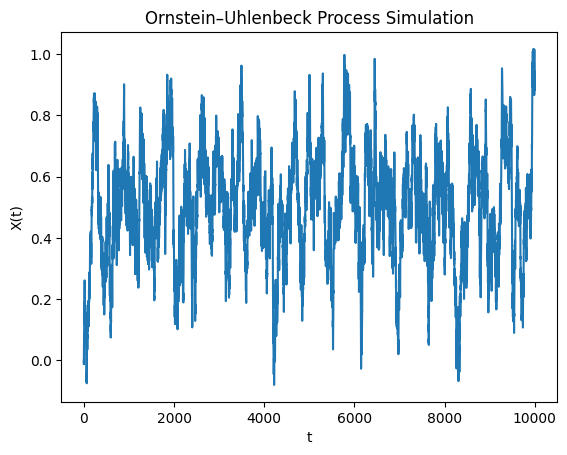

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_process(
    dt=0.01,
    theta=1.2,
    mu=0.5,
    sigma=0.3,
    n_steps=10000
):
    # 初期値 X(0) = 0
    x = np.zeros(n_steps)

    for t in range(1, n_steps):
        # ガウス分布（平均0, 標準偏差 √dt）
        dW = np.random.normal(0, np.sqrt(dt))

        # OU 過程の離散近似
        x[t] = x[t-1] + theta * (mu - x[t-1]) * dt + sigma * dW

    return x

if __name__ == "__main__":
    data = generate_process(
        dt=0.01,
        theta=1.2,
        mu=0.5,
        sigma=0.3,
        n_steps=10000
    )

    plt.plot(data)
    plt.xlabel("t")
    plt.ylabel("X(t)")
    plt.title("Ornstein–Uhlenbeck Process Simulation")
    plt.show()

## 3. パラメータを変える例

1. 平均を変更する（μ = 0.9、揺れを小さく）

```python
data = generate_process(mu=0.9, sigma=0.05)
```

→ 平均 0.9 に強く引き寄せられ、小さく上下する。

2. ランダム性を強くする（σ = 1.0）

```python
data = generate_process(mu=0.5, sigma=1.0)
```

→ 平均は同じだが、上下の振れ幅が激しくなる。

---

## 4.まとめ

- OU 過程は **平均回帰（mean reversion）** を持つ確率過程
- シミュレーションには **Euler–Maruyama 法** が使われる
- ノイズ項は Wiener 過程：  
  $$
  dW_t = \sqrt{\Delta t}\,Z_t,\quad Z_t \sim \mathcal{N}(0,1)
  $$
- θ が大きい → 強く平均へ戻る  
- σ が大きい → ランダムな揺れが増える
- 金利モデル（Vasicek）、ペアトレードのスプレッドなどで必須


#10-4 Vasicek モデル（短金利モデル）の理論まとめ

## 1. Vasicek モデルとは？

- 1977 年に提案された **短金利（short rate）モデル**
- 金利 $ r_t $ の時間変化を **平均回帰（mean reversion）** をもつ確率過程で記述する
- **債券価格・デリバティブ価格・モーゲージモデル** に利用される
- 政策金利や景気など多くの要因が絡むため  
  *金利モデリングは本質的に難しい*  
  → しかし Vasicek は **最もシンプルで強力** なモデルのひとつ

---

## 2. 数理モデル（確率微分方程式）
$$
dr_t = \kappa(\theta - r_t)\,dt + \sigma\, dW_t
$$

#### 用語と意味

| 記号 | 意味 |
|------|------|
| $ r_t $ | 短金利（short rate） |
| $ \kappa $ | 平均回帰速度（speed of mean reversion） |
| $ \theta $ | 金利の長期平均（long-term mean） |
| $ \sigma $ | ボラティリティ（変動性） |
| $ dW_t $ | Wiener（ブラウン運動）過程の微小変化 |

---

## 3. 各項の解釈

 ① 決定論的項（mean reversion）
$$
\kappa(\theta - r_t)\,dt
$$

- 金利が平均 $ \theta$ に戻る力
- $\kappa$ が大きいほど、急速に平均へ吸収される
- 金利が高すぎれば 下に引っ張られ、低すぎれば 上に戻される


 ② 確率（ノイズ）項
$$
\sigma\, dW_t
$$

- ランダム変動（市場ショック、景気ニュースなど）
- $dW_t = \sqrt{dt}\,Z_t,\quad Z_t \sim \mathcal{N}(0,1)$
 → 正規分布で揺れる

---

## 4. Vasicek モデルの特徴

 長所
- 数学的に扱いやすい（解析解が存在）
- 計算が速く、債券価格式も closed-form
- 金利の平均回帰を自然に表現できる

 注意点
- **金利が負になる可能性がある**  
  → 近年は実際にマイナス金利が存在したため問題は小さい場合もある
- 実務では Hull–White モデル（拡張版）がよく使われる

---

## 5. Vasicek は OU 過程そのもの

OU 過程の一般式：

$$
dX_t = \theta(\mu - X_t)\, dt + \sigma dW_t
$$

金利を $ X_t = r_t $ とすれば、**Vasicek = OU 過程の金利バージョン**である。そのため、金利モデルを理解するには OU 過程の理解が不可欠である。

